# Instâncias reais

* **timestamp**: observations timestamps loaded into pandas DataFrame as its index;
* **P-PDG**: pressure variable at the Permanent Downhole Gauge (PDG);
* **P-TPT**: pressure variable at the Temperature and Pressure Transducer (TPT);
* **T-TPT**: temperature variable at the Temperature and Pressure Transducer (TPT);
* **P-MON-CKP**: pressure variable upstream of the production choke (CKP);
* **T-JUS-CKP**: temperature variable downstream of the production choke (CKP);
* **P-JUS-CKGL**: pressure variable upstream of the gas lift choke (CKGL);
* **T-JUS-CKGL**: temperature variable upstream of the gas lift choke (CKGL);
* **QGL**: gas lift flow rate;
* **class**: observations labels associated with three types of periods (normal, fault transient, and faulty steady state).


* **label**: instance label (event type);
* **well**: well name. Hand-drawn and simulated instances have fixed names. Real instances have names masked with incremental id;
* **id**: instance identifier. Hand-drawn and simulated instances have incremental id. Each real instance has an id generated from its first timestamp.

In [1]:
import sys
import os
import pandas as pd
import numpy as np

import joblib
import pickle

from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.metrics  import average_precision_score, make_scorer, roc_curve,f1_score, precision_score, recall_score, fbeta_score, auc, roc_auc_score, accuracy_score, confusion_matrix, classification_report,precision_recall_curve
import seaborn as sns

import matplotlib.pyplot as plt

import shap

from sklearn.model_selection import TimeSeriesSplit

from pyod.models.ecod import ECOD

from pyod.models.suod import SUOD

from pyod.models.xgbod import XGBOD

from pyod.models.loda import LODA

from pyod.models.pca import PCA

from sklearn.neighbors import LocalOutlierFactor

from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

from sklearn.neighbors import LocalOutlierFactor

from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import SGDOneClassSVM
from sklearn.pipeline import make_pipeline
from sklearn.svm import OneClassSVM

import plotly.graph_objects as go

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin


c:\Users\User\anaconda3\envs\PhD\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import plotly.graph_objects as go

In [3]:
def metrics(y_test, y_pred, scores):
    cm = list()
    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm)                      
    plt.figure(figsize=(8,6))  
    sns.heatmap(cm_df, annot=True)
    print("Classification Report: \n", classification_report(y_test, y_pred, digits=5))  


    TN = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]
    TP = cm[1][1]

    print("Specificity:", TN/(TN+FP))


    roc_auc = roc_auc_score(y_test, scores)#, max_fpr=0.1)
    gini = 2*roc_auc -1
    print("Gini: ",gini)
    print("ROC AUC:: ",roc_auc)

In [4]:
from sklearn.metrics import roc_curve, roc_auc_score
import numpy as np

def find_optimal_threshold(y_true, y_scores, max_fpr=None):
    """
    Encontra o threshold ótimo com base na curva ROC,
    considerando apenas FPR <= max_fpr se especificado.
    Retorna fpr, tpr, thresholds, best_threshold e roc_auc.
    """
    # Calcula curva ROC
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)

    # Filtra os pontos se max_fpr for especificado
    if max_fpr is not None:
        mask = fpr <= max_fpr
        fpr = fpr[mask]
        tpr = tpr[mask]
        thresholds = thresholds[mask]

    # AUC usando função apropriada
    roc_auc = roc_auc_score(y_true, y_scores, max_fpr=max_fpr)

    # Índice do ponto ótimo
    optimal_idx = np.argmax(tpr - fpr)
    best_threshold = thresholds[optimal_idx]

    return fpr, tpr, thresholds, best_threshold, roc_auc



def plot_roc_curve(fpr, tpr, thresholds, best_threshold, roc_auc, max_fpr=None):
    """
    Plota a curva ROC a partir de fpr, tpr e thresholds já calculados.
    Destaca o melhor threshold.
    """
    optimal_idx = np.where(thresholds == best_threshold)[0][0]

    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {roc_auc:.3f})', lw=2)
    plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', zorder=5,
                label=f'Melhor Threshold = {best_threshold:.3f}')

    # Linhas auxiliares para melhor visualização
    plt.axhline(y=tpr[optimal_idx], color='gray', linestyle='--', alpha=0.6)
    plt.axvline(x=fpr[optimal_idx], color='gray', linestyle='--', alpha=0.6)

    plt.xlabel('Taxa de Falsos Positivos (FPR)')
    plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
    plt.title(f'Curva ROC{" (FPR ≤ " + str(max_fpr) + ")" if max_fpr else ""}')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

In [5]:
class ToDataFrameTransformer(BaseEstimator, TransformerMixin):
    """
    Transformador para converter arrays NumPy em DataFrames, mantendo os nomes das colunas.
    """
    def __init__(self, columns=None):
        self.columns = columns
    
    def fit(self, X, y=None):
        # Não há nada para ajustar, apenas retorna o próprio objeto
        return self

    def transform(self, X):
        # Converte o array NumPy em DataFrame com os nomes das colunas fornecidos
        if self.columns is not None:
            return pd.DataFrame(X, columns=self.columns)
        return pd.DataFrame(X)

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

In [6]:
def plot_learning_curve_cross_validation(df, title, ylim=None, train_sizes=np.linspace(1, 1000, 1000)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    # plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Interações")
    plt.ylabel("AUC-ROC")

    test_scores_mean = df.iloc[:, 0]
    test_scores_std = df.iloc[:, 1]
    plt.grid()

    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, test_scores_mean, color="g",
             label="Validação cruzada")

    plt.legend(loc="best")
    return plt

In [7]:
train = pd.read_parquet('./dataset/train_agg_dwt.parquet.gzip') 
test = pd.read_parquet('./dataset/test_agg_dwt.parquet.gzip') 

In [8]:
train.head()

,P-PDG_mean,P-JUS-CKGL_skew_L1,P-MON-CKP_mean,P-MON-CKP_std,P-MON-CKP_skew_L0,P-MON-CKP_kurtosis_L0,P-MON-CKP_mean_L1,P-MON-CKP_std_L1,P-MON-CKP_entropy_L1,P-MON-CKP_skew_L1,...,T-TPT_skew_L0,P-TPT_entropy_L1,P-TPT_skew_L1,P-TPT_kurtosis_L1,P-TPT_skew_L0,T-TPT_mean,T-TPT_std,target,timestamp,well
0,0.0,-7.682201,9.397065e+06,19.684417,0.307634,-1.194358,-0.042807,0.323890,4.054446,-0.092052,...,0.000000,4.115644,-4.319906,16.946974,0.0,116.871800,0.000000,1.0,2014-01-24 09:30:00,WELL-00001
1,0.0,-9.508595,9.397186e+06,50.369246,0.020586,-1.207112,-0.014607,0.323596,4.962313,-0.187287,...,0.000000,5.023578,-9.806816,99.180269,0.0,116.871800,0.000000,1.0,2014-01-24 09:35:00,WELL-00001
2,0.0,-9.508595,9.397360e+06,50.374443,-0.006722,-1.207770,0.008154,0.324156,4.961111,-0.315091,...,0.000000,5.023578,-9.806816,99.180269,0.0,116.871800,0.000000,1.0,2014-01-24 09:40:00,WELL-00001
3,0.0,-9.508595,9.397534e+06,50.379760,0.010809,-1.208115,-0.005925,0.328025,4.961434,-0.230442,...,1.873926,5.023578,-9.806816,99.180269,0.0,116.872561,0.001515,1.0,2014-01-24 09:45:00,WELL-00001
4,0.0,-9.508595,9.397708e+06,50.378701,-0.016459,-1.205876,0.011554,0.319672,4.961993,-0.333293,...,0.006362,5.023578,-9.806816,99.180269,0.0,116.887931,0.006060,1.0,2014-01-24 09:50:00,WELL-00001


In [9]:
test.head()

,P-PDG_mean,P-JUS-CKGL_skew_L1,P-MON-CKP_mean,P-MON-CKP_std,P-MON-CKP_skew_L0,P-MON-CKP_kurtosis_L0,P-MON-CKP_mean_L1,P-MON-CKP_std_L1,P-MON-CKP_entropy_L1,P-MON-CKP_skew_L1,...,T-TPT_skew_L0,P-TPT_entropy_L1,P-TPT_skew_L1,P-TPT_kurtosis_L1,P-TPT_skew_L0,T-TPT_mean,T-TPT_std,target,timestamp,well
376538,-6887865.0,10.998622,1.521178e+06,218536.270158,-0.079659,-0.675634,192.851944,3489.718994,3.815005,1.300725,...,0.019816,2.793830,6.569714,55.146750,-0.467070,118.475847,0.000119,0.0,2017-08-23 19:40:00,WELL-00001
376539,-6887865.0,10.998622,1.505095e+06,158973.414833,0.341871,0.097159,-14.542883,4290.028320,3.692357,0.479627,...,0.000000,4.571644,0.023032,21.115869,0.005965,118.476255,0.000115,0.0,2017-08-23 19:45:00,WELL-00001
376540,-6887865.0,10.998622,1.529431e+06,133163.617548,-0.183027,-0.107881,48.409313,3349.570068,3.515687,0.485914,...,-0.109348,3.698463,-9.908874,114.089318,-0.444411,118.476666,0.000121,0.0,2017-08-23 19:50:00,WELL-00001
376541,-6887865.0,10.998622,1.510778e+06,150536.803902,-0.152255,-0.691743,-148.623550,3882.586914,3.702601,-0.626575,...,0.051838,2.811349,-9.133902,100.976882,-0.916041,118.477074,0.000120,0.0,2017-08-23 19:55:00,WELL-00001
376542,-6887865.0,7.737584,1.482189e+06,173782.398244,0.077984,-0.634143,-187.743332,4627.182617,3.877089,-0.229050,...,0.026109,2.396014,3.989285,59.117225,-0.214526,118.477482,0.000125,0.0,2017-08-23 20:00:00,WELL-00001


In [10]:
train.target.value_counts()

target
0.0    19594
1.0     9789
Name: count, dtype: int64

In [11]:
feature_model = [col for col in train.columns if col not in ['timestamp', 'well', 'target']]

In [12]:
development = train.reset_index(drop=True)

# development = development[(development['well']=='WELL-00006')].reset_index(drop=True)

development.shape

(29383, 59)

In [13]:
validation = test.reset_index(drop=True)
validation.shape

(7350, 59)

In [14]:
validation.head()

,P-PDG_mean,P-JUS-CKGL_skew_L1,P-MON-CKP_mean,P-MON-CKP_std,P-MON-CKP_skew_L0,P-MON-CKP_kurtosis_L0,P-MON-CKP_mean_L1,P-MON-CKP_std_L1,P-MON-CKP_entropy_L1,P-MON-CKP_skew_L1,...,T-TPT_skew_L0,P-TPT_entropy_L1,P-TPT_skew_L1,P-TPT_kurtosis_L1,P-TPT_skew_L0,T-TPT_mean,T-TPT_std,target,timestamp,well
0,-6887865.0,10.998622,1.521178e+06,218536.270158,-0.079659,-0.675634,192.851944,3489.718994,3.815005,1.300725,...,0.019816,2.793830,6.569714,55.146750,-0.467070,118.475847,0.000119,0.0,2017-08-23 19:40:00,WELL-00001
1,-6887865.0,10.998622,1.505095e+06,158973.414833,0.341871,0.097159,-14.542883,4290.028320,3.692357,0.479627,...,0.000000,4.571644,0.023032,21.115869,0.005965,118.476255,0.000115,0.0,2017-08-23 19:45:00,WELL-00001
2,-6887865.0,10.998622,1.529431e+06,133163.617548,-0.183027,-0.107881,48.409313,3349.570068,3.515687,0.485914,...,-0.109348,3.698463,-9.908874,114.089318,-0.444411,118.476666,0.000121,0.0,2017-08-23 19:50:00,WELL-00001
3,-6887865.0,10.998622,1.510778e+06,150536.803902,-0.152255,-0.691743,-148.623550,3882.586914,3.702601,-0.626575,...,0.051838,2.811349,-9.133902,100.976882,-0.916041,118.477074,0.000120,0.0,2017-08-23 19:55:00,WELL-00001
4,-6887865.0,7.737584,1.482189e+06,173782.398244,0.077984,-0.634143,-187.743332,4627.182617,3.877089,-0.229050,...,0.026109,2.396014,3.989285,59.117225,-0.214526,118.477482,0.000125,0.0,2017-08-23 20:00:00,WELL-00001


In [15]:
# validation_well = validation[(validation['well']=='WELL-00006')].reset_index(drop=True)

# validation_well.shape

In [16]:
train_no_anomalies = development[development.target==0]
train_no_anomalies.shape

(19594, 59)

In [17]:
development

,P-PDG_mean,P-JUS-CKGL_skew_L1,P-MON-CKP_mean,P-MON-CKP_std,P-MON-CKP_skew_L0,P-MON-CKP_kurtosis_L0,P-MON-CKP_mean_L1,P-MON-CKP_std_L1,P-MON-CKP_entropy_L1,P-MON-CKP_skew_L1,...,T-TPT_skew_L0,P-TPT_entropy_L1,P-TPT_skew_L1,P-TPT_kurtosis_L1,P-TPT_skew_L0,T-TPT_mean,T-TPT_std,target,timestamp,well
0,0.0,-7.682201,9.397065e+06,19.684417,0.307634,-1.194358,-0.042807,0.323890,4.054446,-0.092052,...,0.000000,4.115644,-4.319906,16.946974,0.000000,116.871800,0.000000,1.0,2014-01-24 09:30:00,WELL-00001
1,0.0,-9.508595,9.397186e+06,50.369246,0.020586,-1.207112,-0.014607,0.323596,4.962313,-0.187287,...,0.000000,5.023578,-9.806816,99.180269,0.000000,116.871800,0.000000,1.0,2014-01-24 09:35:00,WELL-00001
2,0.0,-9.508595,9.397360e+06,50.374443,-0.006722,-1.207770,0.008154,0.324156,4.961111,-0.315091,...,0.000000,5.023578,-9.806816,99.180269,0.000000,116.871800,0.000000,1.0,2014-01-24 09:40:00,WELL-00001
3,0.0,-9.508595,9.397534e+06,50.379760,0.010809,-1.208115,-0.005925,0.328025,4.961434,-0.230442,...,1.873926,5.023578,-9.806816,99.180269,0.000000,116.872561,0.001515,1.0,2014-01-24 09:45:00,WELL-00001
4,0.0,-9.508595,9.397708e+06,50.378701,-0.016459,-1.205876,0.011554,0.319672,4.961993,-0.333293,...,0.006362,5.023578,-9.806816,99.180269,0.000000,116.887931,0.006060,1.0,2014-01-24 09:50:00,WELL-00001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29378,0.0,-0.055067,1.449562e+06,11609.985926,0.941673,0.351316,-13.809881,253.246994,3.217738,-2.474636,...,-0.255328,3.288744,-0.041226,25.282544,-0.623781,109.795402,0.007169,1.0,2019-04-03 09:40:00,WELL-00018
29379,0.0,6.496515,1.447438e+06,5761.573674,-0.148824,-0.667873,10.943241,130.115311,3.224156,1.433590,...,-0.371001,3.704392,-0.015057,13.286576,0.251859,109.799910,0.004907,1.0,2019-04-03 09:45:00,WELL-00018
29380,0.0,9.600895,1.444293e+06,6794.752060,-0.855794,0.295732,5.279691,139.586594,2.985486,0.525905,...,0.329778,3.352019,-1.366182,25.782695,0.966040,109.809761,0.012258,1.0,2019-04-03 09:50:00,WELL-00018
29381,0.0,-11.090896,1.438813e+06,9508.739489,1.504364,3.232049,-5.648701,131.525604,2.766471,-0.463865,...,0.644255,3.259306,-4.965078,34.171799,1.098069,109.808114,0.013361,1.0,2019-04-03 09:55:00,WELL-00018


In [18]:
X_dev = development[feature_model].values
y_dev = development['target'].values

In [19]:
y_dev.sum()

9789.0

In [20]:
len(y_dev)

29383

In [21]:
X_no_anomalies = train_no_anomalies[feature_model].values

### Optimization with TPE (Tree-Structured Parzen Estimator)

### Isolation Forest

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html

In [22]:
import optuna
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
import numpy as np

In [23]:
def build_iforest(params):
    estimator = IsolationForest(
        n_estimators=int(params['n_estimators']),
        contamination=params['contamination'],
        max_samples=params['max_samples'],
        max_features=params['max_features'],
        random_state=42,
        n_jobs=-1
    )
    return Pipeline([
        ('scaler', StandardScaler()),
        ('estimator', estimator)
    ])

def transform_iforest_params(params):
    return {
        'n_estimators': int(params[0]),
        'contamination': float(params[1]),
        'max_samples': float(params[2]),
        'max_features': float(params[3])
    }

def evaluate_model(model, dataset, tscv, features):
    roc_auc_scores = []
    for train_index, test_index in tscv.split(dataset):
        train_data = dataset.iloc[train_index]
        X_train = train_data[train_data['target'] == 0][features]
        X_test = dataset.iloc[test_index][features]
        y_test = dataset.iloc[test_index]['target']

        model.fit(X_train)
        y_scores = -model.decision_function(X_test)

        score = roc_auc_score(y_test, y_scores)
        roc_auc_scores.append(score)

    mean_score = np.mean(roc_auc_scores)
    std_score = np.std(roc_auc_scores)

    return mean_score, std_score

def objective_iforest(trial, dataset, tscv, features):
    n_estimators = trial.suggest_int('n_estimators', 5, 256)
    contamination = trial.suggest_float('contamination', 0.0001, 0.005)
    max_samples = trial.suggest_float('max_samples', 0.3, 1.0)
    max_features = trial.suggest_float('max_features', 0.3, 1.0)
    params = [n_estimators, contamination, max_samples, max_features]

    model_params = transform_iforest_params(params)
    model = build_iforest(model_params)
    mean_score, std_score = evaluate_model(model, dataset, tscv, features)

    trial.set_user_attr("roc_auc_mean", mean_score)
    trial.set_user_attr("roc_auc_std", std_score)

    return 100*(mean_score - std_score) 

def optuna_optimization_iforest(dataset, tscv, features, n_trials=50):
    study = optuna.create_study(sampler=optuna.samplers.TPESampler(), direction='maximize')
    study.optimize(lambda trial: objective_iforest(trial, dataset, tscv, features), n_trials=n_trials)

    return study.best_params, study

In [24]:
import time

tscv = TimeSeriesSplit(n_splits=3)
start_time = time.time()  # Inicia o cronômetro

best_params_iforest, study_iforest = optuna_optimization_iforest(development, tscv, feature_model, n_trials=1000)
print(f"Melhores parâmetros para Isolation Forest: {best_params_iforest}")

total_time = time.time() - start_time  # Calcula o tempo total

print("\n--- Resultados Finais ---")
# Melhores parâmetros encontrados
# print("Melhores parâmetros para IsolationForest:", best_params_pca)
print(f"Tempo total de execução: {total_time:.2f} segundos")
print(f"Tempo total de execução: {total_time/60:.2f} minutos")

[I 2025-09-30 16:35:00,300] A new study created in memory with name: no-name-8304b621-a725-4769-98d8-f3b95a6bb00c
[I 2025-09-30 16:35:03,532] Trial 0 finished with value: 88.61250210638264 and parameters: {'n_estimators': 123, 'contamination': 0.0002769330657491468, 'max_samples': 0.8932255786490311, 'max_features': 0.8884985662920455}. Best is trial 0 with value: 88.61250210638264.
[I 2025-09-30 16:35:06,831] Trial 1 finished with value: 83.06918001050721 and parameters: {'n_estimators': 128, 'contamination': 0.00240403366359691, 'max_samples': 0.6352741646432346, 'max_features': 0.7639918681919255}. Best is trial 0 with value: 88.61250210638264.
[I 2025-09-30 16:35:11,219] Trial 2 finished with value: 85.47689527665142 and parameters: {'n_estimators': 183, 'contamination': 0.002998276831319834, 'max_samples': 0.7072356778867845, 'max_features': 0.9105610052760871}. Best is trial 0 with value: 88.61250210638264.
[I 2025-09-30 16:35:12,682] Trial 3 finished with value: 85.5666371335599

Melhores parâmetros para Isolation Forest: {'n_estimators': 32, 'contamination': 0.0038973188342460033, 'max_samples': 0.8883759473226943, 'max_features': 0.4010226673498195}

--- Resultados Finais ---
Tempo total de execução: 1176.32 segundos
Tempo total de execução: 19.61 minutos


In [25]:
data_metrics_iforest = []

for trial in study_iforest.trials:
    data_metrics_iforest.append({
        'trial': trial.number,
        'roc_auc_mean': trial.user_attrs.get('roc_auc_mean'),
        'roc_auc_std': trial.user_attrs.get('roc_auc_std'),
        'value': trial.value,
        **trial.params
    })

df_results_iforest = pd.DataFrame(data_metrics_iforest)
df_results_iforest.to_csv('./metrics_anomaly_detection/results_iforest_tpe_dwt.csv', index=False)
df_results_iforest.head()

,trial,roc_auc_mean,roc_auc_std,value,n_estimators,contamination,max_samples,max_features
0,0,0.916481,0.030356,88.612502,123,0.000277,0.893226,0.888499
1,1,0.892318,0.061627,83.069180,128,0.002404,0.635274,0.763992
2,2,0.905249,0.050480,85.476895,183,0.002998,0.707236,0.910561
3,3,0.907229,0.051563,85.566637,59,0.004189,0.992330,0.871367
4,4,0.910333,0.046792,86.354154,88,0.002524,0.506921,0.765252


<module 'matplotlib.pyplot' from 'c:\\Users\\User\\anaconda3\\envs\\PhD\\Lib\\site-packages\\matplotlib\\pyplot.py'>

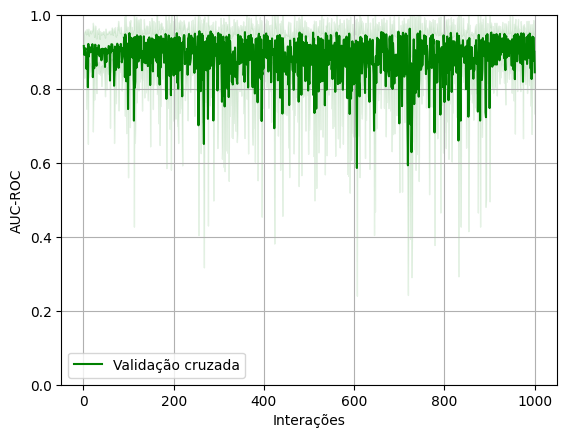

In [26]:
results_df_iforest2 = df_results_iforest[['roc_auc_mean', 'roc_auc_std']]

plot_learning_curve_cross_validation(results_df_iforest2, title="iforest", ylim=(0, 1), train_sizes=np.linspace(1, 1000, 1000))

In [27]:
df_results_iforest = pd.read_csv('./metrics_anomaly_detection/results_iforest_tpe_dwt.csv')   

df_results_iforest['roc_auc_adjusted'] = df_results_iforest['roc_auc_mean'] - df_results_iforest['roc_auc_std']  

# Encontrar o índice do maior valor na nova coluna  
best_params_idx = df_results_iforest['roc_auc_adjusted'].idxmax()  

# Obter os melhores parâmetros com base nesse índice  
# best_params = df_results_iforest.loc[999]
best_params = df_results_iforest.loc[best_params_idx]  

print("\nMétricas:", best_params) 


Métricas: trial               357.000000
roc_auc_mean          0.954027
roc_auc_std           0.014533
value                93.949349
n_estimators         32.000000
contamination         0.003897
max_samples           0.888376
max_features          0.401023
roc_auc_adjusted      0.939493
Name: 357, dtype: float64


In [28]:
n_estimators_best = int(best_params_iforest.get('n_estimators'))
contamination_best = round(float(best_params_iforest.get('contamination')), 5)
max_samples_best = round(float(best_params_iforest.get('max_samples')), 2)
max_features_best = round(float(best_params_iforest.get('max_features')), 2)

print(f"Melhores parâmetros para Isolation Forest: n_estimators={n_estimators_best}, contamination={contamination_best}, max_samples={max_samples_best}, max_features={max_features_best}")

Melhores parâmetros para Isolation Forest: n_estimators=32, contamination=0.0039, max_samples=0.89, max_features=0.4


In [29]:
estimator  = IsolationForest(
    n_estimators=n_estimators_best,
    contamination=contamination_best,
    max_samples=max_samples_best,
    max_features=max_features_best,
    random_state=42
)

pipe_model_iforest = Pipeline([
            ('scaler', StandardScaler()),
            ('to_dataframe', ToDataFrameTransformer(columns=feature_model)),
            ('estimator', estimator)
        ])

pipe_model_iforest.fit(X_no_anomalies)

Pipeline(steps=[('scaler', StandardScaler()),
                ('to_dataframe',
                 ToDataFrameTransformer(columns=['P-PDG_mean',
                                                 'P-JUS-CKGL_skew_L1',
                                                 'P-MON-CKP_mean',
                                                 'P-MON-CKP_std',
                                                 'P-MON-CKP_skew_L0',
                                                 'P-MON-CKP_kurtosis_L0',
                                                 'P-MON-CKP_mean_L1',
                                                 'P-MON-CKP_std_L1',
                                                 'P-MON-CKP_entropy_L1',
                                                 'P-MON-CKP_skew_L1',
                                                 'P-MON-CKP_kurtosis_L1',
                                                 'T-JUS-CKP_mean',
                                                 'T-JUS-CKP_std',
                                                 'T-TPT_s...
                                                 'T-JUS-CKP_kurtosis_L1',
                                                 'P-JUS-CKGL_mean',
                                                 'P-JUS-CKGL_std',
                                                 'P-JUS-CKGL_skew_L0',
                                                 'P-JUS-CKGL_kurtosis_L0',
                                                 'P-JUS-CKGL_mean_L1',
                                                 'P-JUS-CKGL_std_L1',
                                                 'P-JUS-CKGL_entropy_L1',
                                                 'T-JUS-CKP_kurtosis_L0',
                                                 'T-TPT_entropy_L1',
                                                 'T-TPT_kurtosis_L1', ...])),
                ('estimator',
                 IsolationForest(contamination=0.0039, max_features=0.4,
                                 max_samples=0.89, n_estimators=32,
                                 random_state=42))])

In [30]:
scores_dev = -pipe_model_iforest.decision_function(X_dev)

fpr, tpr, thresholds, best_threshold, roc_auc = find_optimal_threshold(y_dev, scores_dev, max_fpr=1)
print(f"Melhor Threshold (FPR ≤ 0.1): {best_threshold:.4f}, AUC: {roc_auc:.4f}")

y_pred = (scores_dev >= best_threshold).astype(int)
print("Melhore threshold: ", best_threshold)


Melhor Threshold (FPR ≤ 0.1): -0.1116, AUC: 0.9562
Melhore threshold:  -0.11164668495935154


Classification Report: 
               precision    recall  f1-score   support

         0.0    0.93943   0.93804   0.93874     19594
         1.0    0.87635   0.87895   0.87765      9789

    accuracy                        0.91835     29383
   macro avg    0.90789   0.90849   0.90819     29383
weighted avg    0.91842   0.91835   0.91838     29383

Specificity: 0.9380422578340308
Gini:  0.9124323991555079
ROC AUC::  0.956216199577754


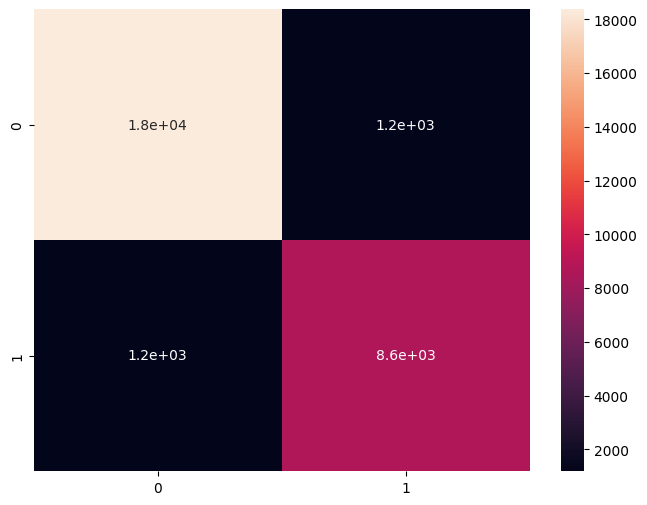

In [31]:
metrics(y_dev, y_pred, scores_dev)

In [32]:
X_valid = validation[feature_model].values
y_valid = validation['target'].values

In [33]:
scores_valid = -pipe_model_iforest.decision_function(X_valid)
y_pred = (scores_valid >= best_threshold).astype(int)
# y_pred = pipe_model_iforest.predict(X_valid)
# y_pred = np.where(y_pred == -1, 1, 0)  

In [34]:
# scores_valid = -pipe_model_iforest.decision_function(X_valid)
# final_auc = roc_auc_score(y_valid, scores_valid)
# # Calcular a curva ROC  
# fpr, tpr, thresholds = roc_curve(y_valid, scores_valid)  

# print(f"AUC final com melhores hiperparâmetros: {final_auc:.4f}")

Classification Report: 
               precision    recall  f1-score   support

         0.0    0.98908   0.67484   0.80228      5099
         1.0    0.57169   0.98312   0.72297      2251

    accuracy                        0.76925      7350
   macro avg    0.78038   0.82898   0.76263      7350
weighted avg    0.86125   0.76925   0.77799      7350

Specificity: 0.6748382035693273
Gini:  0.7245424643589577
ROC AUC::  0.8622712321794789


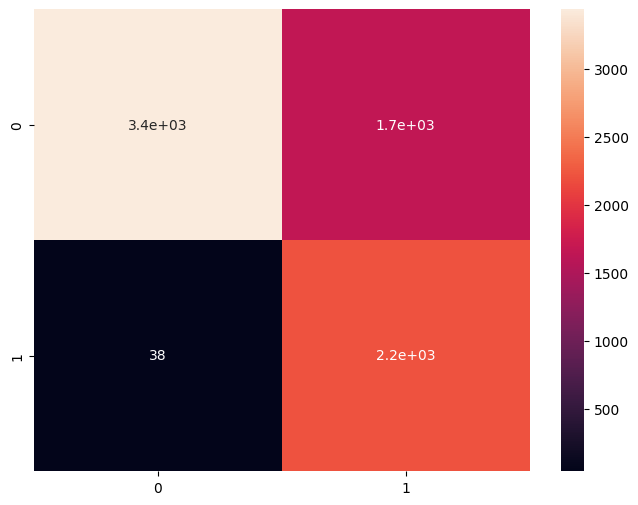

In [35]:
metrics(y_valid, y_pred, scores_valid)

In [36]:
validation['scores_forest']=-pipe_model_iforest.decision_function(X_valid)

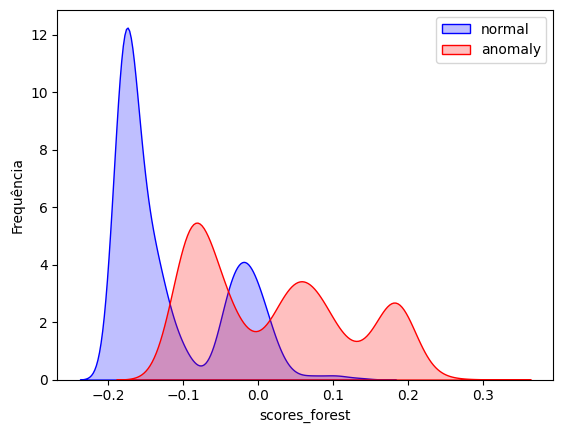

In [37]:
g = sns.kdeplot(validation["scores_forest"][(validation["target"] == 0) & (validation["scores_forest"].notnull())], color="Blue", fill = True)
g = sns.kdeplot(validation["scores_forest"][(validation["target"] == 1) & (validation["scores_forest"].notnull())], color="Red", fill = True)

g.set_xlabel("scores_forest")
g.set_ylabel("Frequência")
g = g.legend(['normal', 'anomaly'])

In [38]:
with open('./models/pipeline_iForest_tpe_dwt.pkl', 'wb') as file: 
    pickle.dump(pipe_model_iforest, file)

## Local Outlier Factor

In [39]:
from sklearn.neighbors import LocalOutlierFactor

In [40]:
def build_lof(params):
    model = LocalOutlierFactor(
        n_neighbors=int(params['n_neighbors']),
        contamination=params['contamination'],
        novelty=True,
        n_jobs=-1
    )
    return Pipeline([
        ('scaler', StandardScaler()),
        ('estimator', model)
    ])

def transform_lof_params(params):
    return {
        'n_neighbors': int(params[0]),
        'contamination': float(params[1])
    }

def objective_lof(trial, dataset, tscv, features):
    n_neighbors = trial.suggest_int('n_neighbors', 3, 25)
    contamination = trial.suggest_float('contamination', 0.0001, 0.005)
    params = [n_neighbors, contamination]

    model_params = transform_lof_params(params)
    model = build_lof(model_params)
    mean_score, std_score = evaluate_model(model, dataset, tscv, features)

    trial.set_user_attr("roc_auc_mean", mean_score)
    trial.set_user_attr("roc_auc_std", std_score)

    return 100*(mean_score - std_score) 

def optuna_optimization_lof(dataset, tscv, features, n_trials=50):
    study = optuna.create_study(sampler=optuna.samplers.TPESampler(), direction='maximize')
    study.optimize(lambda trial: objective_lof(trial, dataset, tscv, features), n_trials=n_trials)

    return study.best_params, study

In [41]:
import time
tscv = TimeSeriesSplit(n_splits=3)
start_time = time.time()  # Inicia o cronômetro

best_params_lof, study_lof = optuna_optimization_lof(development, tscv, feature_model, n_trials=1000)
print(f"Melhores parâmetros para LOF: {best_params_lof}")

total_time = time.time() - start_time  # Calcula o tempo total
print(f"Tempo total de execução: {total_time:.2f} segundos")
print(f"Tempo total de execução: {total_time/60:.2f} minutos")

[I 2025-09-30 16:54:40,303] A new study created in memory with name: no-name-eca995c2-a05a-4491-b3d0-acd7bb9dcca7
[I 2025-09-30 16:54:46,937] Trial 0 finished with value: 68.44068328143129 and parameters: {'n_neighbors': 23, 'contamination': 0.004229357275581982}. Best is trial 0 with value: 68.44068328143129.
[I 2025-09-30 16:54:53,301] Trial 1 finished with value: 73.60698782581053 and parameters: {'n_neighbors': 7, 'contamination': 0.00035239775648541013}. Best is trial 1 with value: 73.60698782581053.
[I 2025-09-30 16:54:59,435] Trial 2 finished with value: 72.08757508927384 and parameters: {'n_neighbors': 15, 'contamination': 0.003015448610841405}. Best is trial 1 with value: 73.60698782581053.
[I 2025-09-30 16:55:05,552] Trial 3 finished with value: 68.44068328143129 and parameters: {'n_neighbors': 23, 'contamination': 0.0027962744343498053}. Best is trial 1 with value: 73.60698782581053.
[I 2025-09-30 16:55:11,841] Trial 4 finished with value: 68.44068328143129 and parameters: {

Melhores parâmetros para LOF: {'n_neighbors': 3, 'contamination': 0.0014307045075898789}
Tempo total de execução: 4719.64 segundos
Tempo total de execução: 78.66 minutos


In [42]:
data_metrics_lof = []

for trial in study_lof.trials:
    data_metrics_lof.append({
        'trial': trial.number,
        'roc_auc_mean': trial.user_attrs.get('roc_auc_mean'),
        'roc_auc_std': trial.user_attrs.get('roc_auc_std'),
        'value': trial.value,
        **trial.params
    })

df_results_lof = pd.DataFrame(data_metrics_lof)
df_results_lof.to_csv('./metrics_anomaly_detection/results_lof_tpe_dwt.csv', index=False)
df_results_lof.head()

,trial,roc_auc_mean,roc_auc_std,value,n_neighbors,contamination
0,0,0.814994,0.130587,68.440683,23,0.004229
1,1,0.845447,0.109377,73.606988,7,0.000352
2,2,0.838088,0.117212,72.087575,15,0.003015
3,3,0.814994,0.130587,68.440683,23,0.002796
4,4,0.814994,0.130587,68.440683,23,0.002821


<module 'matplotlib.pyplot' from 'c:\\Users\\User\\anaconda3\\envs\\PhD\\Lib\\site-packages\\matplotlib\\pyplot.py'>

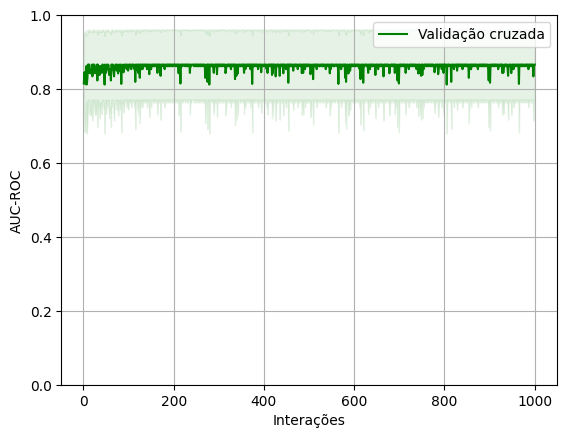

In [43]:
results_df_lof2 = df_results_lof[['roc_auc_mean', 'roc_auc_std']]

plot_learning_curve_cross_validation(results_df_lof2, title="lof", ylim=(0, 1), train_sizes=np.linspace(1, 1000, 1000))

In [44]:
df_results_lof = pd.read_csv('./metrics_anomaly_detection/results_lof_tpe_dwt.csv')   

df_results_lof['roc_auc_adjusted'] = df_results_lof['roc_auc_mean'] - df_results_lof['roc_auc_std']  

# Encontrar o índice do maior valor na nova coluna  
best_params_idx = df_results_lof['roc_auc_adjusted'].idxmax()  

# Obter os melhores parâmetros com base nesse índice  
# best_params = df_results_lof.loc[999]
best_params = df_results_lof.loc[best_params_idx]  

print("\nMétricas:", best_params) 


Métricas: trial                9.000000
roc_auc_mean         0.866174
roc_auc_std          0.094860
value               77.131472
n_neighbors          3.000000
contamination        0.001431
roc_auc_adjusted     0.771315
Name: 9, dtype: float64


In [45]:
# best_params_lof = {
#  'contamination': 0.001554,
#  'n_neighbors': 25}

In [46]:
n_neighbors_best = int(round(best_params_lof.get('n_neighbors'), 0))
contamination_best = round(float(best_params_lof.get('contamination')), 5)

print(f"Melhores hiperparâmetros encontrados: n_neighbors={n_neighbors_best}, contamination={contamination_best}")

Melhores hiperparâmetros encontrados: n_neighbors=3, contamination=0.00143


In [47]:
estimator_lof  = LocalOutlierFactor(
    n_neighbors=n_neighbors_best,
    contamination=contamination_best,
    novelty=True,
    n_jobs=-1
)

estimator_lof 

LocalOutlierFactor(contamination=0.00143, n_jobs=-1, n_neighbors=3,
                   novelty=True)

In [48]:
pipe_model_lof = Pipeline([
            ('scaler', StandardScaler()),
            ('to_dataframe', ToDataFrameTransformer(columns=feature_model)),
            ('estimator', estimator_lof)
        ])

In [49]:
pipe_model_lof.fit(X_no_anomalies)

Pipeline(steps=[('scaler', StandardScaler()),
                ('to_dataframe',
                 ToDataFrameTransformer(columns=['P-PDG_mean',
                                                 'P-JUS-CKGL_skew_L1',
                                                 'P-MON-CKP_mean',
                                                 'P-MON-CKP_std',
                                                 'P-MON-CKP_skew_L0',
                                                 'P-MON-CKP_kurtosis_L0',
                                                 'P-MON-CKP_mean_L1',
                                                 'P-MON-CKP_std_L1',
                                                 'P-MON-CKP_entropy_L1',
                                                 'P-MON-CKP_skew_L1',
                                                 'P-MON-CKP_kurtosis_L1',
                                                 'T-JUS-CKP_mean',
                                                 'T-JUS-CKP_std',
                                                 'T-TPT_s...
                                                 'T-JUS-CKP_skew_L1',
                                                 'T-JUS-CKP_kurtosis_L1',
                                                 'P-JUS-CKGL_mean',
                                                 'P-JUS-CKGL_std',
                                                 'P-JUS-CKGL_skew_L0',
                                                 'P-JUS-CKGL_kurtosis_L0',
                                                 'P-JUS-CKGL_mean_L1',
                                                 'P-JUS-CKGL_std_L1',
                                                 'P-JUS-CKGL_entropy_L1',
                                                 'T-JUS-CKP_kurtosis_L0',
                                                 'T-TPT_entropy_L1',
                                                 'T-TPT_kurtosis_L1', ...])),
                ('estimator',
                 LocalOutlierFactor(contamination=0.00143, n_jobs=-1,
                                    n_neighbors=3, novelty=True))])

In [50]:
scores_dev = -pipe_model_lof.decision_function(X_dev)

fpr, tpr, thresholds, best_threshold, roc_auc = find_optimal_threshold(y_dev, scores_dev, max_fpr=1)
print(f"Melhor Threshold (FPR ≤ 1): {best_threshold:.4f}, AUC: {roc_auc:.4f}")

y_pred = (scores_dev >= best_threshold).astype(int)
print("Melhore threshold: ", best_threshold)

# y_pred = pipe_model_lof.predict(X_dev)
# y_pred = np.where(y_pred == -1, 1, 0)  

Melhor Threshold (FPR ≤ 1): -3.4890, AUC: 0.9691
Melhore threshold:  -3.488988707408237


Classification Report: 
               precision    recall  f1-score   support

         0.0    0.94144   0.95009   0.94574     19594
         1.0    0.89822   0.88170   0.88989      9789

    accuracy                        0.92730     29383
   macro avg    0.91983   0.91590   0.91781     29383
weighted avg    0.92704   0.92730   0.92713     29383

Specificity: 0.9500867612534449
Gini:  0.9382031342077246
ROC AUC::  0.9691015671038623


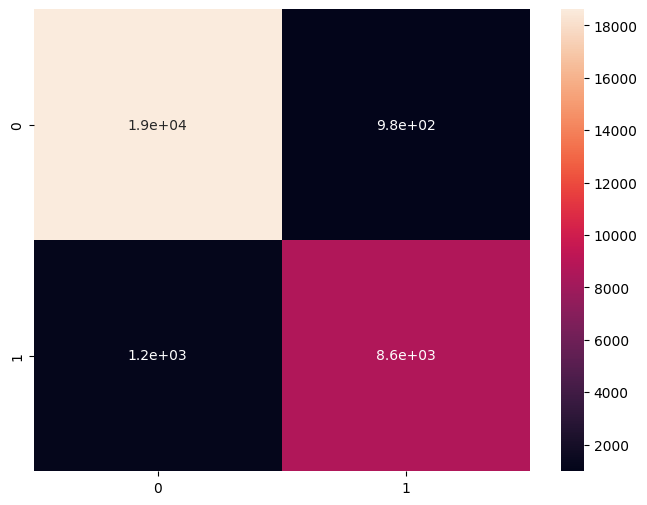

In [51]:
metrics(y_dev, y_pred, scores_dev)

In [52]:
X_valid = validation[feature_model].values
y_valid = validation['target'].values

In [53]:
scores_valid = -pipe_model_lof.decision_function(X_valid)
y_pred = (scores_valid >= best_threshold).astype(int)

# y_pred = pipe_model_lof.predict(X_valid)
# y_pred = np.where(y_pred == -1, 1, 0)  

Classification Report: 
               precision    recall  f1-score   support

         0.0    0.99970   0.64503   0.78412      5099
         1.0    0.55419   0.99956   0.71304      2251

    accuracy                        0.75361      7350
   macro avg    0.77694   0.82229   0.74858      7350
weighted avg    0.86326   0.75361   0.76235      7350

Specificity: 0.6450284369484213
Gini:  0.9922393124356317
ROC AUC::  0.9961196562178158


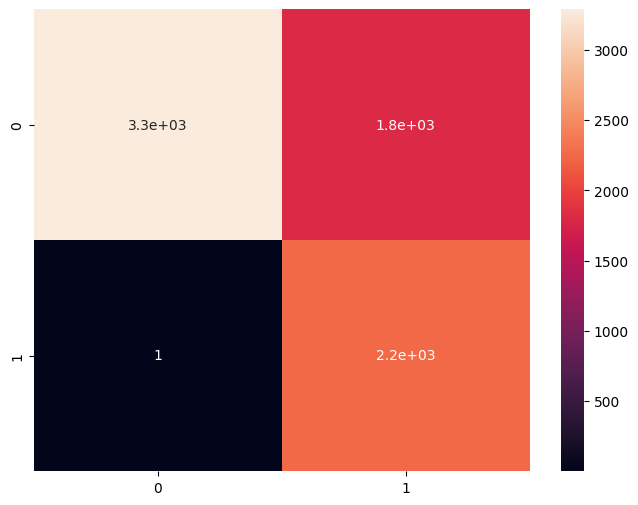

In [54]:
metrics(y_valid, y_pred, scores_valid)

In [55]:
with open('./models/pipeline_LOF_tpe_dwt.pkl', 'wb') as file: 
    pickle.dump(pipe_model_lof, file)

## Algorithms Pyod
https://pyod.readthedocs.io/en/latest/

In [56]:
def evaluate_model_pyod(model, dataset, tscv, features):
    roc_auc_scores = []
    for train_index, test_index in tscv.split(dataset):
        train_data = dataset.iloc[train_index]
        X_train = train_data[train_data['target'] == 0][features]
        X_test = dataset.iloc[test_index][features]
        y_test = dataset.iloc[test_index]['target']

        model.fit(X_train)
        y_scores = model.decision_function(X_test)

        score = roc_auc_score(y_test, y_scores)
        roc_auc_scores.append(score)

    mean_score = np.mean(roc_auc_scores)
    std_score = np.std(roc_auc_scores)

    return mean_score, std_score

#### PCA

In [57]:
from pyod.models.pca import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import optuna

# Função para construir o modelo PCA com pipeline
def build_pca(params):
    model = PCA(
        contamination=params['contamination'], 
        n_components=params['n_components']
    )
    return Pipeline([
        ('scaler', StandardScaler()),
        ('estimator', model)
    ])

# Transformação de vetor para dicionário de parâmetros
def transform_pca_params(params):
    return {
        'contamination': float(params[0]), 
        'n_components': float(params[1])
    }

# Função objetivo do Optuna
def objective_pca(trial, dataset, tscv, features):
    contamination = trial.suggest_float('contamination', 0.0001, 0.005)
    n_components = trial.suggest_float('n_components', 0.5, 1.0)

    # Parâmetros como vetor para função de transformação
    params = [contamination, n_components]
    model_params = transform_pca_params(params)

    model = build_pca(model_params)
    mean_score, std_score = evaluate_model_pyod(model, dataset, tscv, features)

    trial.set_user_attr("roc_auc_mean", mean_score)
    trial.set_user_attr("roc_auc_std", std_score)

    return 100*(mean_score - std_score) 

# Execução da otimização com TPE
def optuna_optimization_pca(dataset, tscv, features, n_trials=50):
    study = optuna.create_study(sampler=optuna.samplers.TPESampler(), direction='maximize')
    study.optimize(lambda trial: objective_pca(trial, dataset, tscv, features), n_trials=n_trials)
    return study.best_params, study


In [58]:
import time

start_time = time.time()  # Inicia o cronômetro

best_params_pca, study_pca = optuna_optimization_pca(development, tscv, feature_model, n_trials=1000)
print(f"Melhores parâmetros para pca: {best_params_pca}")

total_time = time.time() - start_time  # Calcula o tempo total
print(f"Tempo total de execução: {total_time:.2f} segundos")
print(f"Tempo total de execução: {total_time/60:.2f} minutos")

[I 2025-09-30 18:13:28,982] A new study created in memory with name: no-name-51d35a51-4ba5-4600-8434-a76e73075d87
[I 2025-09-30 18:13:30,180] Trial 0 finished with value: 81.16545735766067 and parameters: {'contamination': 0.0004873954255952716, 'n_components': 0.8253476599624341}. Best is trial 0 with value: 81.16545735766067.
[I 2025-09-30 18:13:34,000] Trial 1 finished with value: 81.35560237261743 and parameters: {'contamination': 0.003764440157827496, 'n_components': 0.6911555688875535}. Best is trial 1 with value: 81.35560237261743.
[I 2025-09-30 18:13:34,470] Trial 2 finished with value: 81.03051629786232 and parameters: {'contamination': 0.003968127370197453, 'n_components': 0.9027120726876717}. Best is trial 1 with value: 81.35560237261743.
[I 2025-09-30 18:13:34,986] Trial 3 finished with value: 80.98531372564062 and parameters: {'contamination': 0.0014617784048161228, 'n_components': 0.9910329945968147}. Best is trial 1 with value: 81.35560237261743.
[I 2025-09-30 18:13:36,5

Melhores parâmetros para pca: {'contamination': 0.0001326156879649376, 'n_components': 0.5123155577618009}
Tempo total de execução: 1984.67 segundos
Tempo total de execução: 33.08 minutos


In [59]:
data_metrics_pca = []

for trial in study_pca.trials:
    data_metrics_pca.append({
        'trial': trial.number,
        'roc_auc_mean': trial.user_attrs.get('roc_auc_mean'),
        'roc_auc_std': trial.user_attrs.get('roc_auc_std'),
        'value': trial.value,
        **trial.params
    })

df_results_pca = pd.DataFrame(data_metrics_pca)
df_results_pca.to_csv('./metrics_anomaly_detection/results_pca_tpe_dwt.csv', index=False)
df_results_pca.head()

,trial,roc_auc_mean,roc_auc_std,value,contamination,n_components
0,0,0.893242,0.081587,81.165457,0.000487,0.825348
1,1,0.894175,0.080619,81.355602,0.003764,0.691156
2,2,0.892632,0.082326,81.030516,0.003968,0.902712
3,3,0.892420,0.082567,80.985314,0.001462,0.991033
4,4,0.893154,0.081719,81.143460,0.001494,0.814255


<module 'matplotlib.pyplot' from 'c:\\Users\\User\\anaconda3\\envs\\PhD\\Lib\\site-packages\\matplotlib\\pyplot.py'>

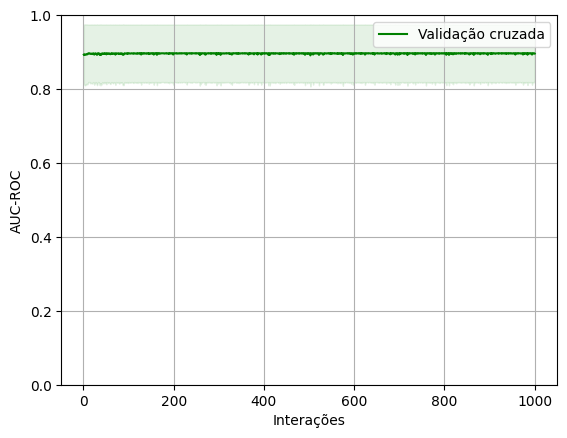

In [60]:
results_df_pca2 = df_results_pca[['roc_auc_mean', 'roc_auc_std']]

plot_learning_curve_cross_validation(results_df_pca2, title="pca", ylim=(0, 1), train_sizes=np.linspace(1, 1000, 1000))

In [61]:
df_results_pca = pd.read_csv('./metrics_anomaly_detection/results_pca_tpe_dwt.csv')   

df_results_pca['roc_auc_adjusted'] = df_results_pca['roc_auc_mean'] - df_results_pca['roc_auc_std']  

# Encontrar o índice do maior valor na nova coluna  
best_params_idx = df_results_pca['roc_auc_adjusted'].idxmax()  

# Obter os melhores parâmetros com base nesse índice  
# best_params = df_results_pca.loc[999]
best_params = df_results_pca.loc[best_params_idx]  

print("\nMétricas:", best_params) 


Métricas: trial               10.000000
roc_auc_mean         0.896717
roc_auc_std          0.077748
value               81.896897
contamination        0.000133
n_components         0.512316
roc_auc_adjusted     0.818969
Name: 10, dtype: float64


In [62]:
n_components_best = float(round(best_params.get('n_components'), 2))
contamination_best = round(float(best_params.get('contamination')), 5)

print(f"Melhores hiperparâmetros encontrados: n_components={n_components_best}, contamination={contamination_best}")

Melhores hiperparâmetros encontrados: n_components=0.51, contamination=0.00013


In [63]:
if n_components_best==1.0:
    n_components_best=0.99
else:
    pass

In [64]:
estimator = PCA(random_state=42, 
                contamination = contamination_best,
                # n_components = n_components_best
                
                )
estimator

PCA(contamination=0.00013, copy=True, iterated_power='auto',
  n_components=None, n_selected_components=None, random_state=42,
  standardization=True, svd_solver='auto', tol=0.0, weighted=True,
  whiten=False)

In [65]:
# estimator = PCA(** best_params_pca, random_state=42)

pipe_model_pca = Pipeline([
            ('scaler', StandardScaler()),
            ('to_dataframe', ToDataFrameTransformer(columns=feature_model)), 
            ('estimator', estimator)
        ])

pipe_model_pca.fit(X_no_anomalies)

Pipeline(steps=[('scaler', StandardScaler()),
                ('to_dataframe',
                 ToDataFrameTransformer(columns=['P-PDG_mean',
                                                 'P-JUS-CKGL_skew_L1',
                                                 'P-MON-CKP_mean',
                                                 'P-MON-CKP_std',
                                                 'P-MON-CKP_skew_L0',
                                                 'P-MON-CKP_kurtosis_L0',
                                                 'P-MON-CKP_mean_L1',
                                                 'P-MON-CKP_std_L1',
                                                 'P-MON-CKP_entropy_L1',
                                                 'P-MON-CKP_skew_L1',
                                                 'P-MON-CKP_kurtosis_L1',
                                                 'T-JUS-CKP_mean',
                                                 'T-JUS-CKP_std',
                                                 'T-TPT_s...
                                                 'P-JUS-CKGL_kurtosis_L0',
                                                 'P-JUS-CKGL_mean_L1',
                                                 'P-JUS-CKGL_std_L1',
                                                 'P-JUS-CKGL_entropy_L1',
                                                 'T-JUS-CKP_kurtosis_L0',
                                                 'T-TPT_entropy_L1',
                                                 'T-TPT_kurtosis_L1', ...])),
                ('estimator',
                 PCA(contamination=0.00013, copy=True, iterated_power='auto',
  n_components=None, n_selected_components=None, random_state=42,
  standardization=True, svd_solver='auto', tol=0.0, weighted=True,
  whiten=False))])

In [66]:
# y_pred = pipe_model_pca.predict(development[feature_model])

scores_dev = pipe_model_pca.decision_function(X_dev)

fpr, tpr, thresholds, best_threshold, roc_auc = find_optimal_threshold(y_dev, scores_dev, max_fpr=1)
print(f"Melhor Threshold (FPR ≤ 1): {best_threshold:.4f}, AUC: {roc_auc:.4f}")

y_pred = (scores_dev >= best_threshold).astype(int)
print("Melhore threshold: ", best_threshold)

Melhor Threshold (FPR ≤ 1): 1508890130.5768, AUC: 0.9357
Melhore threshold:  1508890130.57678


Classification Report: 
               precision    recall  f1-score   support

         0.0    0.93146   0.94672   0.93903     19594
         1.0    0.88973   0.86056   0.87490      9789

    accuracy                        0.91801     29383
   macro avg    0.91060   0.90364   0.90696     29383
weighted avg    0.91756   0.91801   0.91766     29383

Specificity: 0.9467183831785241
Gini:  0.8714783430850264
ROC AUC::  0.9357391715425132


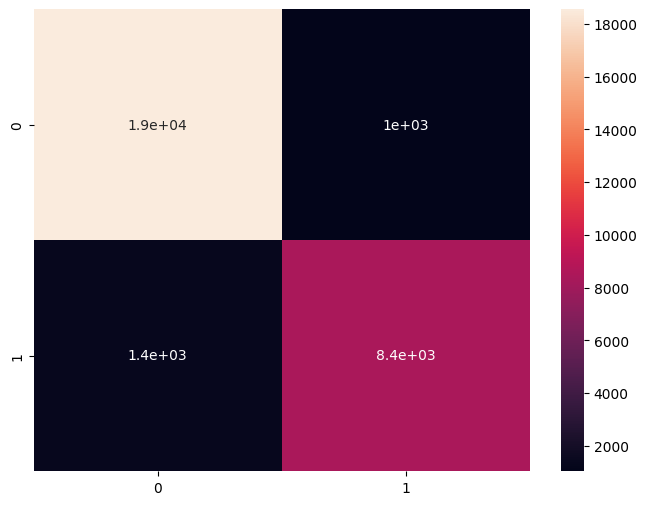

In [67]:
metrics(y_dev, y_pred, scores_dev)

In [68]:
X_valid = validation[feature_model].values
y_valid = validation['target'].values

In [69]:
scores_valid = pipe_model_pca.decision_function(X_valid)
y_pred = (scores_valid >= best_threshold).astype(int)
# y_pred = pipe_model_pca.predict(validation[feature_model])
# y_test = validation.target.values

Classification Report: 
               precision    recall  f1-score   support

         0.0    1.00000   0.94685   0.97270      5099
         1.0    0.89255   1.00000   0.94322      2251

    accuracy                        0.96313      7350
   macro avg    0.94627   0.97343   0.95796      7350
weighted avg    0.96709   0.96313   0.96367      7350

Specificity: 0.9468523239850951
Gini:  0.991564795807995
ROC AUC::  0.9957823979039975


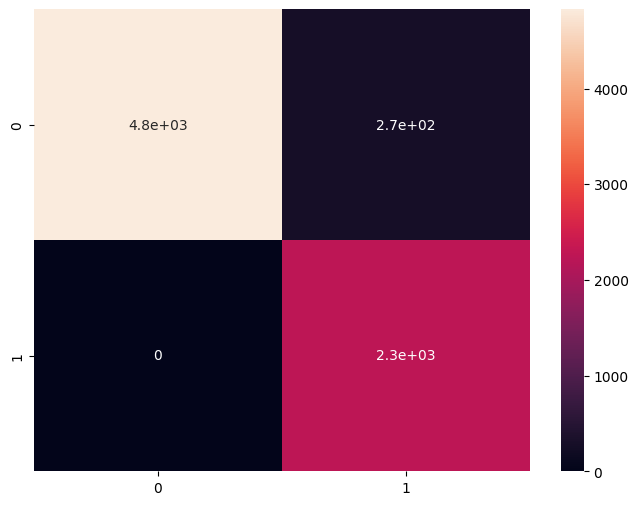

In [70]:
metrics(y_valid, y_pred, scores_valid)

In [71]:
with open('./models/pipeline_PCA_tpe_dwt.pkl', 'wb') as file: 
    pickle.dump(pipe_model_pca, file)

#### LODA

In [72]:
from pyod.models.loda import LODA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import optuna

# Função para construir o modelo LODA
def build_loda(params):
    model = LODA(
        contamination=params['contamination'],
        n_bins=params['n_bins'],
        n_random_cuts=params['n_random_cuts']
    )
    return Pipeline([
        ('scaler', StandardScaler()),
        ('estimator', model)
    ])

# Função para transformar vetor de parâmetros em dicionário
def transform_loda_params(params):
    return {
        'contamination': float(params[0]),
        'n_bins': int(params[1]),
        'n_random_cuts': int(params[2])
    }

# Função objetivo para o Optuna
def objective_loda(trial, dataset, tscv, features):
    contamination = trial.suggest_float('contamination', 0.0001, 0.005)
    n_bins = trial.suggest_int('n_bins', 50, 5000)
    n_random_cuts = trial.suggest_int('n_random_cuts', 10, 1000)

    params = [contamination, n_bins, n_random_cuts]
    model_params = transform_loda_params(params)
    model = build_loda(model_params)

    mean_score, std_score = evaluate_model_pyod(model, dataset, tscv, features)

    trial.set_user_attr("roc_auc_mean", mean_score)
    trial.set_user_attr("roc_auc_std", std_score)

    return 100*(mean_score - std_score) 

# Execução da otimização com TPESampler
def optuna_optimization_loda(dataset, tscv, features, n_trials=50):
    study = optuna.create_study(sampler=optuna.samplers.TPESampler(), direction='maximize')
    study.optimize(lambda trial: objective_loda(trial, dataset, tscv, features), n_trials=n_trials)
    return study.best_params, study


In [73]:
import time

start_time = time.time()  # Inicia o cronômetro

best_params_loda, study_loda = optuna_optimization_loda(development, tscv, feature_model, n_trials=1000)
print(f"Melhores parâmetros para loda: {best_params_loda}")

total_time = time.time() - start_time  # Calcula o tempo total
print(f"Tempo total de execução: {total_time:.2f} segundos")
print(f"Tempo total de execução: {total_time/60:.2f} minutos")

[I 2025-09-30 18:46:36,114] A new study created in memory with name: no-name-c8cc5ece-3cd2-4949-b158-d8f11a75ea65
[I 2025-09-30 18:46:42,089] Trial 0 finished with value: 78.95794418581322 and parameters: {'contamination': 0.002034648238138896, 'n_bins': 950, 'n_random_cuts': 950}. Best is trial 0 with value: 78.95794418581322.
[I 2025-09-30 18:46:47,559] Trial 1 finished with value: 81.97017198639107 and parameters: {'contamination': 0.003069648724595501, 'n_bins': 531, 'n_random_cuts': 947}. Best is trial 1 with value: 81.97017198639107.
[I 2025-09-30 18:46:48,534] Trial 2 finished with value: 74.0022687003115 and parameters: {'contamination': 0.004847680114873943, 'n_bins': 2414, 'n_random_cuts': 145}. Best is trial 1 with value: 81.97017198639107.
[I 2025-09-30 18:46:52,784] Trial 3 finished with value: 76.68747528623571 and parameters: {'contamination': 0.004457696526528189, 'n_bins': 3946, 'n_random_cuts': 626}. Best is trial 1 with value: 81.97017198639107.
[I 2025-09-30 18:46:5

Melhores parâmetros para loda: {'contamination': 0.0013658498454592464, 'n_bins': 141, 'n_random_cuts': 221}
Tempo total de execução: 3547.87 segundos
Tempo total de execução: 59.13 minutos


In [74]:
data_metrics_loda = []

for trial in study_loda.trials:
    data_metrics_loda.append({
        'trial': trial.number,
        'roc_auc_mean': trial.user_attrs.get('roc_auc_mean'),
        'roc_auc_std': trial.user_attrs.get('roc_auc_std'),
        'value': trial.value,
        **trial.params
    })

df_results_loda = pd.DataFrame(data_metrics_loda)
df_results_loda.to_csv('./metrics_anomaly_detection/results_loda_tpe_dwt.csv', index=False)
df_results_loda.head()

,trial,roc_auc_mean,roc_auc_std,value,contamination,n_bins,n_random_cuts
0,0,0.884948,0.095369,78.957944,0.002035,950,950
1,1,0.895416,0.075714,81.970172,0.003070,531,947
2,2,0.859416,0.119393,74.002269,0.004848,2414,145
3,3,0.871249,0.104374,76.687475,0.004458,3946,626
4,4,0.884655,0.097215,78.743919,0.003999,3236,903


<module 'matplotlib.pyplot' from 'c:\\Users\\User\\anaconda3\\envs\\PhD\\Lib\\site-packages\\matplotlib\\pyplot.py'>

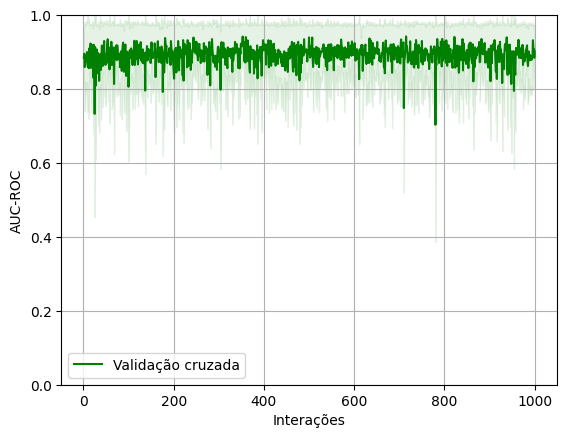

In [75]:
results_df_loda2 = df_results_loda[['roc_auc_mean', 'roc_auc_std']]

plot_learning_curve_cross_validation(results_df_loda2, title="loda", ylim=(0, 1), train_sizes=np.linspace(1, 1000, 1000))

In [76]:
df_results_loda = pd.read_csv('./metrics_anomaly_detection/results_loda_tpe_dwt.csv')   

df_results_loda['roc_auc_adjusted'] = df_results_loda['roc_auc_mean'] - df_results_loda['roc_auc_std']  

# Encontrar o índice do maior valor na nova coluna  
best_params_idx = df_results_loda['roc_auc_adjusted'].idxmax()  

# Obter os melhores parâmetros com base nesse índice  
# best_params = df_results_loda.loc[999]
best_params = df_results_loda.loc[best_params_idx]  

print("\nMétricas:", best_params) 


Métricas: trial               937.000000
roc_auc_mean          0.939889
roc_auc_std           0.035421
value                90.446786
contamination         0.001366
n_bins              141.000000
n_random_cuts       221.000000
roc_auc_adjusted      0.904468
Name: 937, dtype: float64


In [77]:
best_params_loda

{'contamination': 0.0013658498454592464, 'n_bins': 141, 'n_random_cuts': 221}

In [78]:
n_random_cuts_best = int(best_params_loda.get('n_random_cuts'))
contamination_best = round(float(best_params_loda.get('contamination')), 5)
n_bins_best = int(best_params_loda.get('n_bins'))


print(f"Melhores hiperparâmetros encontrados: n_random_cuts={n_random_cuts_best}, contamination={contamination_best}, "
      f"n_bins={n_bins_best}")


Melhores hiperparâmetros encontrados: n_random_cuts=221, contamination=0.00137, n_bins=141


In [79]:
estimator = LODA(contamination=contamination_best, n_bins=n_bins_best, n_random_cuts=n_random_cuts_best)

pipe_model_loda = Pipeline([
            ('scaler', StandardScaler()),
            ('to_dataframe', ToDataFrameTransformer(columns=feature_model)), 
            ('estimator', estimator)
        ])

pipe_model_loda.fit(X_no_anomalies)

Pipeline(steps=[('scaler', StandardScaler()),
                ('to_dataframe',
                 ToDataFrameTransformer(columns=['P-PDG_mean',
                                                 'P-JUS-CKGL_skew_L1',
                                                 'P-MON-CKP_mean',
                                                 'P-MON-CKP_std',
                                                 'P-MON-CKP_skew_L0',
                                                 'P-MON-CKP_kurtosis_L0',
                                                 'P-MON-CKP_mean_L1',
                                                 'P-MON-CKP_std_L1',
                                                 'P-MON-CKP_entropy_L1',
                                                 'P-MON-CKP_skew_L1',
                                                 'P-MON-CKP_kurtosis_L1',
                                                 'T-JUS-CKP_mean',
                                                 'T-JUS-CKP_std',
                                                 'T-TPT_s...
                                                 'T-JUS-CKP_entropy_L1',
                                                 'T-JUS-CKP_skew_L1',
                                                 'T-JUS-CKP_kurtosis_L1',
                                                 'P-JUS-CKGL_mean',
                                                 'P-JUS-CKGL_std',
                                                 'P-JUS-CKGL_skew_L0',
                                                 'P-JUS-CKGL_kurtosis_L0',
                                                 'P-JUS-CKGL_mean_L1',
                                                 'P-JUS-CKGL_std_L1',
                                                 'P-JUS-CKGL_entropy_L1',
                                                 'T-JUS-CKP_kurtosis_L0',
                                                 'T-TPT_entropy_L1',
                                                 'T-TPT_kurtosis_L1', ...])),
                ('estimator',
                 LODA(contamination=0.00137, n_bins=141, n_random_cuts=221))])

In [80]:
scores_dev = pipe_model_loda.decision_function(X_dev)

fpr, tpr, thresholds, best_threshold, roc_auc = find_optimal_threshold(y_dev, scores_dev, max_fpr=1)
print(f"Melhor Threshold (FPR ≤ 1): {best_threshold:.4f}, AUC: {roc_auc:.4f}")

y_pred = (scores_dev >= best_threshold).astype(int)
print("Melhore threshold: ", best_threshold)

Melhor Threshold (FPR ≤ 1): 0.0144, AUC: 0.9379
Melhore threshold:  0.014419338181205573


In [81]:
# y_pred = pipe_model_loda.predict(X_dev)

Classification Report: 
               precision    recall  f1-score   support

         0.0    0.93258   0.91145   0.92190     19594
         1.0    0.83045   0.86812   0.84887      9789

    accuracy                        0.89702     29383
   macro avg    0.88152   0.88978   0.88538     29383
weighted avg    0.89856   0.89702   0.89757     29383

Specificity: 0.911452485454731
Gini:  0.8758287463729042
ROC AUC::  0.9379143731864521


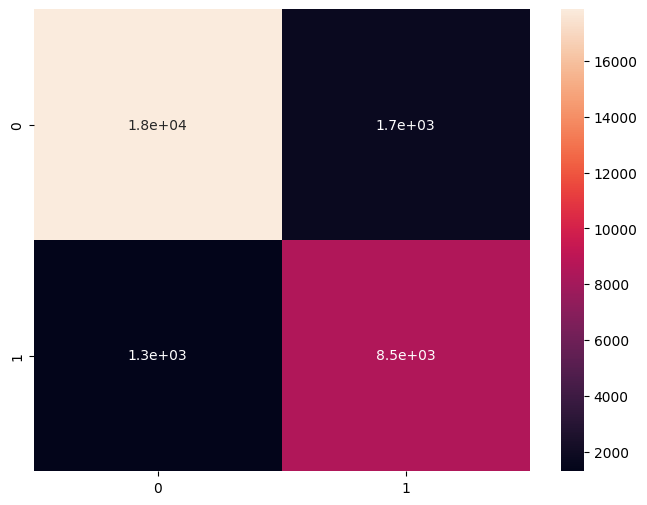

In [82]:
metrics(y_dev, y_pred, scores_dev)

In [83]:
X_valid = validation[feature_model].values
y_valid = validation['target'].values

In [84]:
scores_valid = pipe_model_loda.decision_function(X_valid)
y_pred = (scores_valid >= best_threshold).astype(int)

# y_pred = pipe_model_loda.predict(X_valid)
# y_test = validation.target.values

Classification Report: 
               precision    recall  f1-score   support

         0.0    1.00000   0.80408   0.89140      5099
         1.0    0.69262   1.00000   0.81840      2251

    accuracy                        0.86408      7350
   macro avg    0.84631   0.90204   0.85490      7350
weighted avg    0.90586   0.86408   0.86904      7350

Specificity: 0.8040792312218082
Gini:  0.9609297874540779
ROC AUC::  0.9804648937270389


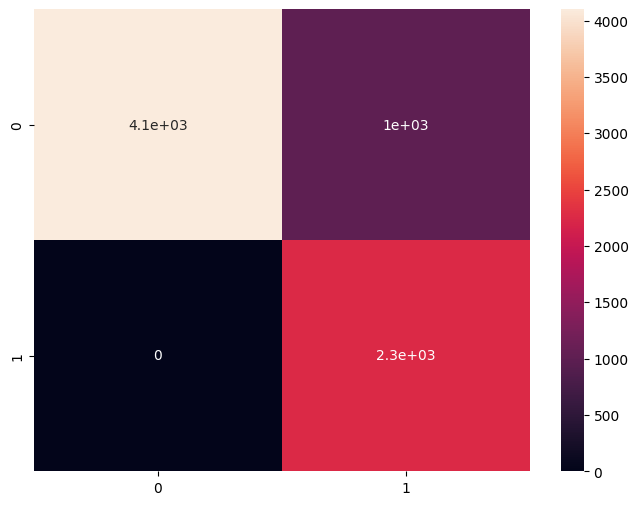

In [85]:
metrics(y_valid, y_pred, scores_valid)

In [86]:
with open('./models/pipeline_LODA_tpe_dwt.pkl', 'wb') as file: 
    pickle.dump(pipe_model_loda, file)

### OCSVM

In [87]:
from pyod.models.ocsvm import OCSVM
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import optuna

def build_ocsvm(params):
    model = OCSVM(
        kernel=params['kernel'],
        nu=params['nu'],
        gamma=params['gamma']
    )
    return Pipeline([
        ('scaler', StandardScaler()),
        ('estimator', model)
    ])

def transform_ocsvm_params(params):
    return {
        'kernel': params[0],
        'nu': float(params[1]),
        'gamma': float(params[2])
    }

def objective_ocsvm(trial, dataset, tscv, features):
    kernel = trial.suggest_categorical('kernel', ['rbf', 'linear', 'poly', 'sigmoid'])
    nu = trial.suggest_float('nu', 0.0001, 0.005)
    gamma = trial.suggest_float('gamma', 0.001, 0.1)

    params = [kernel, nu, gamma]
    model_params = transform_ocsvm_params(params)
    model = build_ocsvm(model_params)

    mean_score, std_score = evaluate_model_pyod(model, dataset, tscv, features)

    trial.set_user_attr("roc_auc_mean", mean_score)
    trial.set_user_attr("roc_auc_std", std_score)

    return 100 * (mean_score - std_score)

def optuna_optimization_ocsvm(dataset, tscv, features, n_trials=50):
    study = optuna.create_study(sampler=optuna.samplers.TPESampler(), direction='maximize')
    study.optimize(lambda trial: objective_ocsvm(trial, dataset, tscv, features), n_trials=n_trials)
    return study.best_params, study


In [88]:
import time

start_time = time.time()  # Inicia o cronômetro

best_params_ocsvm, study_ocsvm = optuna_optimization_ocsvm(development, tscv, feature_model, n_trials=1000)
print(f"Melhores parâmetros para ocsvm: {best_params_ocsvm}")

total_time = time.time() - start_time  # Calcula o tempo total
print(f"Tempo total de execução: {total_time:.2f} segundos")
print(f"Tempo total de execução: {total_time/60:.2f} minutos")

[I 2025-09-30 19:45:47,514] A new study created in memory with name: no-name-35b4a1e7-8d1e-4417-804b-432f116d125f
[I 2025-09-30 19:46:06,568] Trial 0 finished with value: 74.01065944096074 and parameters: {'kernel': 'rbf', 'nu': 0.002173722440931521, 'gamma': 0.06662254544657725}. Best is trial 0 with value: 74.01065944096074.
[I 2025-09-30 19:46:10,282] Trial 1 finished with value: 60.44265194522973 and parameters: {'kernel': 'poly', 'nu': 0.0029664947465901314, 'gamma': 0.04781126714278951}. Best is trial 0 with value: 74.01065944096074.
[I 2025-09-30 19:46:13,272] Trial 2 finished with value: -3.384602617428989 and parameters: {'kernel': 'linear', 'nu': 0.0011307004308792614, 'gamma': 0.01155526950722853}. Best is trial 0 with value: 74.01065944096074.
[I 2025-09-30 19:46:16,070] Trial 3 finished with value: -3.675900931417747 and parameters: {'kernel': 'linear', 'nu': 0.001125506704461517, 'gamma': 0.02880205209725416}. Best is trial 0 with value: 74.01065944096074.
[I 2025-09-30 1

Melhores parâmetros para ocsvm: {'kernel': 'rbf', 'nu': 0.000668326328242987, 'gamma': 0.0010023484988983342}
Tempo total de execução: 2277.07 segundos
Tempo total de execução: 37.95 minutos


In [89]:
data_metrics_ocsvm = []

for trial in study_ocsvm.trials:
    data_metrics_ocsvm.append({
        'trial': trial.number,
        'roc_auc_mean': trial.user_attrs.get('roc_auc_mean'),
        'roc_auc_std': trial.user_attrs.get('roc_auc_std'),
        'value': trial.value,
        **trial.params
    })

df_results_ocsvm = pd.DataFrame(data_metrics_ocsvm)
df_results_ocsvm.to_csv('./metrics_anomaly_detection/results_ocsvm_tpe_dwt.csv', index=False)
df_results_ocsvm.head()

,trial,roc_auc_mean,roc_auc_std,value,kernel,nu,gamma
0,0,0.853595,0.113489,74.010659,rbf,0.002174,0.066623
1,1,0.655124,0.050697,60.442652,poly,0.002966,0.047811
2,2,0.359970,0.393816,-3.384603,linear,0.001131,0.011555
3,3,0.386473,0.423232,-3.675901,linear,0.001126,0.028802
4,4,0.447364,0.308486,13.887845,sigmoid,0.002969,0.040123


<module 'matplotlib.pyplot' from 'c:\\Users\\User\\anaconda3\\envs\\PhD\\Lib\\site-packages\\matplotlib\\pyplot.py'>

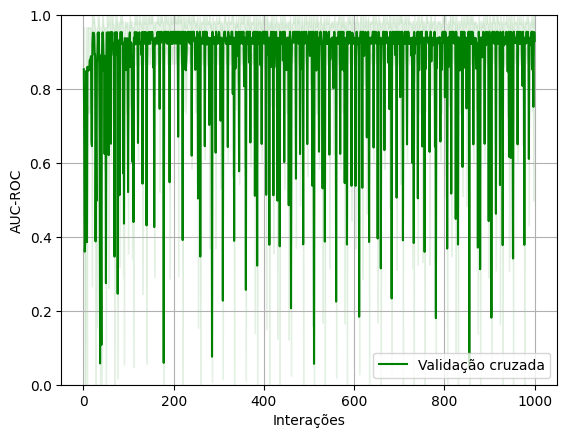

In [90]:
results_df_ocsvm2 = df_results_ocsvm[['roc_auc_mean', 'roc_auc_std']]

plot_learning_curve_cross_validation(results_df_ocsvm2, title="ocsvm", ylim=(0, 1), train_sizes=np.linspace(1, 1000, 1000))

In [91]:
df_results_ocsvm = pd.read_csv('./metrics_anomaly_detection/results_ocsvm_tpe_dwt.csv')   

df_results_ocsvm['roc_auc_adjusted'] = df_results_ocsvm['roc_auc_mean'] - df_results_ocsvm['roc_auc_std']  

# Encontrar o índice do maior valor na nova coluna  
best_params_idx = df_results_ocsvm['roc_auc_adjusted'].idxmax()  

# Obter os melhores parâmetros com base nesse índice  
# best_params = df_results_ocsvm.loc[999]
best_params = df_results_ocsvm.loc[best_params_idx]  

print("\nMétricas:", best_params) 


Métricas: trial                     257
roc_auc_mean          0.95509
roc_auc_std          0.041428
value               91.366229
kernel                    rbf
nu                   0.000668
gamma                0.001002
roc_auc_adjusted     0.913662
Name: 257, dtype: object


In [92]:
kernel_best = best_params_ocsvm.get('kernel')
nu_best = round(float(best_params_ocsvm.get('nu')), 5)
gamma_best = round(float(best_params_ocsvm.get('gamma')), 3)

print(f"Melhores hiperparâmetros encontrados: kernel={kernel_best}, nu={nu_best}, gamma={gamma_best}")


Melhores hiperparâmetros encontrados: kernel=rbf, nu=0.00067, gamma=0.001


In [93]:
estimator = OCSVM(
    kernel=kernel_best,
    nu=nu_best,
    gamma=gamma_best
)

In [94]:
pipe_model_ocsvm = Pipeline([
    ('scaler', StandardScaler()),
    ('to_dataframe', ToDataFrameTransformer(columns=feature_model)), 
    ('estimator', estimator)
])

# Treinar no conjunto sem anomalias
pipe_model_ocsvm.fit(X_no_anomalies)

Pipeline(steps=[('scaler', StandardScaler()),
                ('to_dataframe',
                 ToDataFrameTransformer(columns=['P-PDG_mean',
                                                 'P-JUS-CKGL_skew_L1',
                                                 'P-MON-CKP_mean',
                                                 'P-MON-CKP_std',
                                                 'P-MON-CKP_skew_L0',
                                                 'P-MON-CKP_kurtosis_L0',
                                                 'P-MON-CKP_mean_L1',
                                                 'P-MON-CKP_std_L1',
                                                 'P-MON-CKP_entropy_L1',
                                                 'P-MON-CKP_skew_L1',
                                                 'P-MON-CKP_kurtosis_L1',
                                                 'T-JUS-CKP_mean',
                                                 'T-JUS-CKP_std',
                                                 'T-TPT_s...
                                                 'P-JUS-CKGL_std',
                                                 'P-JUS-CKGL_skew_L0',
                                                 'P-JUS-CKGL_kurtosis_L0',
                                                 'P-JUS-CKGL_mean_L1',
                                                 'P-JUS-CKGL_std_L1',
                                                 'P-JUS-CKGL_entropy_L1',
                                                 'T-JUS-CKP_kurtosis_L0',
                                                 'T-TPT_entropy_L1',
                                                 'T-TPT_kurtosis_L1', ...])),
                ('estimator',
                 OCSVM(cache_size=200, coef0=0.0, contamination=0.1, degree=3, gamma=0.001,
   kernel='rbf', max_iter=-1, nu=0.00067, shrinking=True, tol=0.001,
   verbose=False))])

In [95]:
scores_dev = pipe_model_ocsvm.decision_function(X_dev)

# Encontrar o melhor threshold
fpr, tpr, thresholds, best_threshold, roc_auc = find_optimal_threshold(y_dev, scores_dev, max_fpr=1.0)
print(f"Melhor Threshold (FPR ≤ 1): {best_threshold:.4f}, AUC: {roc_auc:.4f}")

# Prever usando o threshold escolhido
y_pred = (scores_dev >= best_threshold).astype(int)
print("Melhor threshold: ", best_threshold)

Melhor Threshold (FPR ≤ 1): -0.2849, AUC: 0.9462
Melhor threshold:  -0.2849415072600704


Classification Report: 
               precision    recall  f1-score   support

         0.0    0.93131   0.96524   0.94797     19594
         1.0    0.92496   0.85749   0.88995      9789

    accuracy                        0.92935     29383
   macro avg    0.92813   0.91137   0.91896     29383
weighted avg    0.92919   0.92935   0.92864     29383

Specificity: 0.9652444625905889
Gini:  0.8923355788665805
ROC AUC::  0.9461677894332903


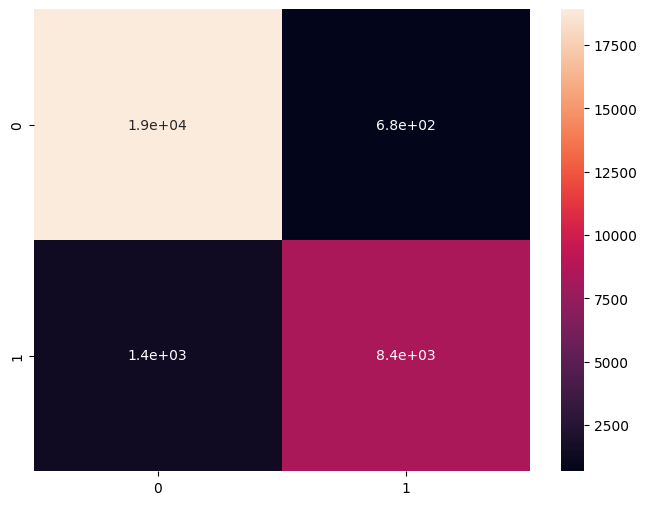

In [96]:
metrics(y_dev, y_pred, scores_dev)

In [97]:
X_valid = validation[feature_model].values
y_valid = validation['target'].values

In [98]:
scores_valid = pipe_model_ocsvm.decision_function(X_valid)
y_pred = (scores_valid >= best_threshold).astype(int)
# y_test = validation.target.values
# y_pred = pipe_model_ocsvm.predict(X_valid)

# y_pred = np.where(y_pred == -1, 1, 0)  

Classification Report: 
               precision    recall  f1-score   support

         0.0    1.00000   0.95764   0.97836      5099
         1.0    0.91244   1.00000   0.95422      2251

    accuracy                        0.97061      7350
   macro avg    0.95622   0.97882   0.96629      7350
weighted avg    0.97319   0.97061   0.97097      7350

Specificity: 0.9576387526966071
Gini:  0.9865473051614462
ROC AUC::  0.9932736525807231


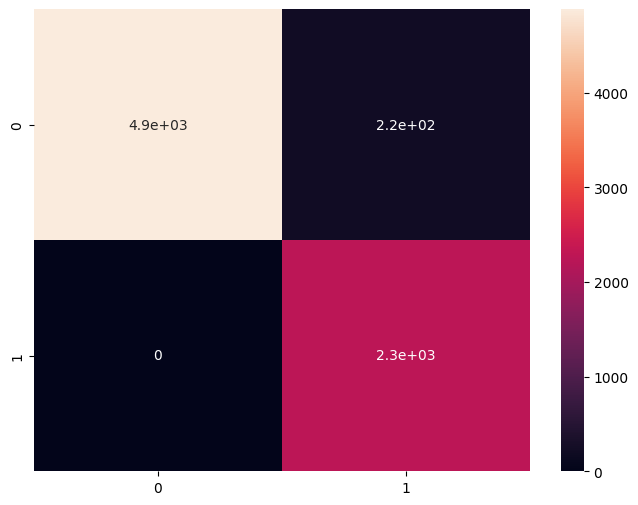

In [99]:
metrics(y_valid, y_pred, scores_valid)

In [100]:
validation['scores_ocsvm']= pipe_model_ocsvm.decision_function(X_valid)

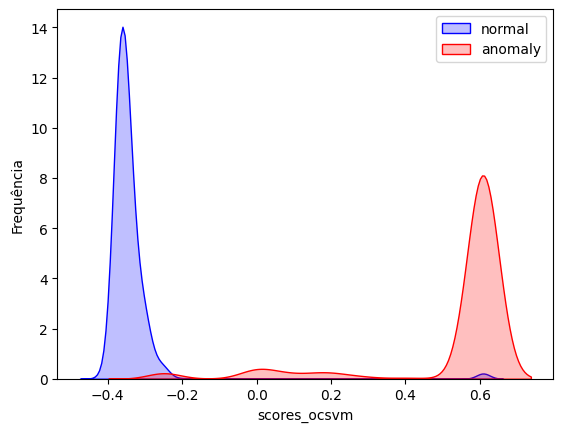

In [101]:
g = sns.kdeplot(validation["scores_ocsvm"][(validation["target"] == 0) & (validation["scores_ocsvm"].notnull())], color="Blue", fill = True)
g = sns.kdeplot(validation["scores_ocsvm"][(validation["target"] == 1) & (validation["scores_ocsvm"].notnull())], color="Red", fill = True)

g.set_xlabel("scores_ocsvm")
g.set_ylabel("Frequência")
g = g.legend(['normal', 'anomaly'])

In [102]:
with open('./models/pipeline_OCSVM_tpe_dwt.pkl', 'wb') as file: 
    pickle.dump(pipe_model_ocsvm, file)